# PreLab

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
from hmmlearn.hmm import GaussianHMM

def get_price(filename,name,start_date,end_date):
    data = pd.read_csv(filename)
    data = data[data.Name == name]
    tmp = data[data.Date > start_date]
    data2 = tmp[tmp.Date < end_date]
    return data2

def get_features(filename,name,start_date,end_date):
    data = get_price(filename, name, start_date, end_date)
    volume = data['Volume']
    close = data['Close']
    logDel = np.log(np.array(data['High'])) - np.log(np.array(data['Low']))
    logRet_1 = np.array(np.diff(np.log(close)))  # 这个作为后面计算收益使用
    logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
    logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))
    logDel = logDel[5:]
    logRet_1 = logRet_1[4:]
    close = close[5:]
    Date = data.Date[5:]
    A = np.column_stack([logDel, logRet_5, logVol_5])
    return A, Date, close, logRet_1

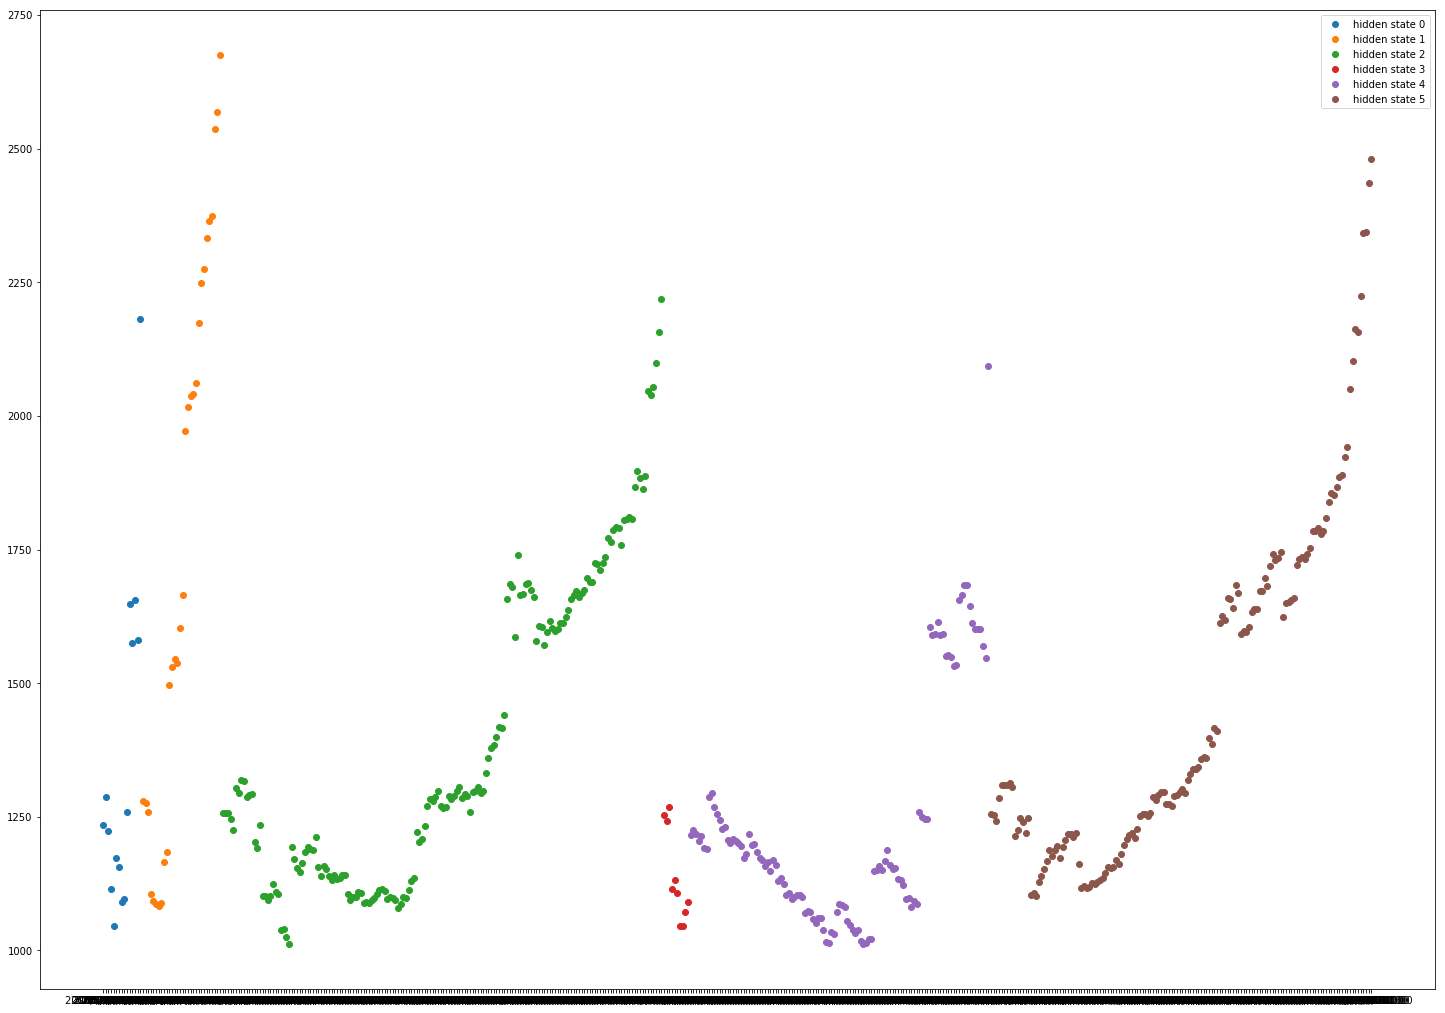

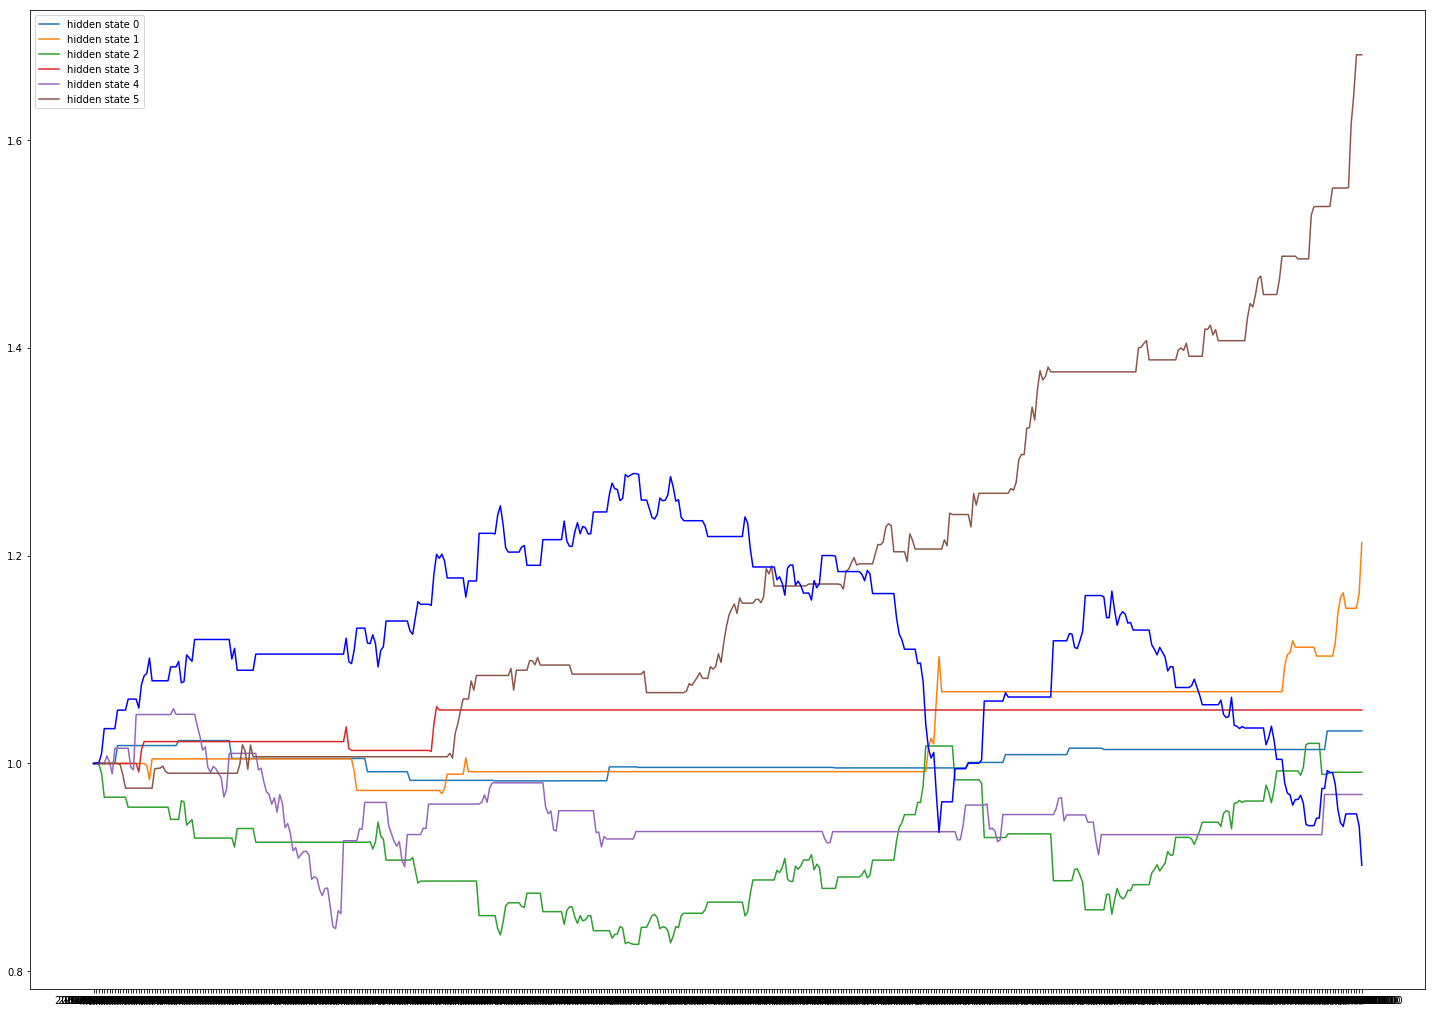

In [2]:
beginDate = '2005-02-01'
endDate = '2007-12-31'
A, Date, close, logRet_1 = get_features("1990-201310.csv", "SH000001", start_date=beginDate, end_date=endDate)

model = GaussianHMM(n_components= 6, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)

plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="left")

res = pd.DataFrame({'Date':Date,'logRet_1':logRet_1,'state':hidden_states}).set_index('Date')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    df = res.logRet_1
    res['state_ret%s'%i] = df.multiply(pos)
    plt.plot_date(Date,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")

long = (hidden_states==0) + (hidden_states==3)
short = (hidden_states==1) + (hidden_states==2)
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])
res['ret'] = df.multiply(long) - df.multiply(short)
plt.plot(Date, np.exp(res['ret'].cumsum()), 'b-', label = 'hidden state')

# Lab